In [2]:
"""
Purpose of notebook: 1: read a grd file and plot it using GMT
                     2: subsample the grid and save to csv
                     3: plot the subsampled points using GMT
                     
Requirements: gmt, geopy, pandas
"""

#########################################################################
# define filename and use gmt grdinfo to display information about grid #
#########################################################################

FILENAME = 'RR.P.mod.VG.Y.grd'
# ! indicates a shell command, -La scans the date to report real z stats
! gmt grdinfo $FILENAME -La

ERROR 4: `RR.grd' not recognized as a supported file format.
grdinfo [ERROR]: gmt_M_err_trap: 2
grdinfo (gmt_api.c:2181(gmt_get_header)): Not a supported grid format [RR.grd]
[Session gmt (0)]: Error returned from GMT API: GMT_GRID_READ_ERROR (18)
[Session gmt (0)]: Error returned from GMT API: GMT_GRID_READ_ERROR (18)


In [2]:
#######################################
# make a color plot to visualize data #
#######################################

# use automatic=True to find the bounds of the region from the grid file,
# or use automatic=False to supply different bounds to plot 
automatic = False

if automatic:
    # first store the region that the grid file encompasses as variables to pass to GMT
    XMIN = ! gmt grdinfo $FILENAME -Cn -o0
    XMAX = ! gmt grdinfo $FILENAME -Cn -o1
    YMIN = ! gmt grdinfo $FILENAME -Cn -o2
    YMAX = ! gmt grdinfo $FILENAME -Cn -o3
    # the above gmt grdinfo command stores the values in a list. we only want the string
    XMIN = XMIN[0]
    XMAX = XMAX[0]
    YMIN = YMIN[0]
    YMAX = YMAX[0]
else:
    # define bounds to plot
    XMIN = -122.1
    XMAX = -121.4
    YMIN = 43.7
    YMAX = 44.5

# feed the data to gmt, write to color_grid.png
! gmt begin color_grid png

    # create the map frame and set the region and projection
!    gmt basemap -R$XMIN/$XMAX/$YMIN/$YMAX -JM15c -Baf

    # plot topography using gmt built-in dataset at the highest resolution
!    gmt grdimage @earth_relief_01s -Cgray -I+d

    # make a new colormap that only covers the values of interest for the grid
!    gmt makecpt -Cseis -T-140/35

    # plot grid as colored map using grdimage, transparency 60%
!    gmt grdimage $FILENAME -t60 -Q

    # show the colorbar, ticks every 25 mm, add title
!    gmt colorbar -B25 -Bx+l"range change [mm]"

! gmt end show

grdblend [WARNING]: File @N40W130.earth_relief_15s_p.nc has different increments (0.00416666666667/0.00416666666667) than the output grid (0.000277777777778/0.000277777777778) - must resample
grdblend [WARNING]: File @N40W130.earth_relief_15s_p.nc coordinates are phase-shifted w.r.t. the output grid - must resample


,longitude,latitude,displacement
0,-122.100000,44.5,-9999.0
1,-122.099167,44.5,-9999.0
2,-122.098333,44.5,-9999.0
3,-122.097500,44.5,-9999.0
4,-122.096667,44.5,-9999.0


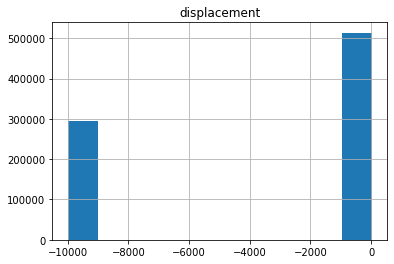

In [3]:
########################################
# subsample the grid file to 85 points #
########################################
"""
# for a simply regridding use gmt to resample the grid as below:
# define output file name
OUTFILE = 'resampled.grd'
# resample using grdsample, -I denotes number of nodes, -R denotes subregion, 
! gmt grdsample $FILENAME -I0.02 -R$XMIN/$XMAX/$YMIN/$YMAX -G$OUTFILE
# inspect the details of the new file
! gmt grdinfo $OUTFILE -La
"""
import pandas as pd

# define region of interest to subsample
XMIN = -122.1
XMAX = -121.4
YMIN = 43.7
YMAX = 44.5

# write subregion of grd file to text to sample the grid pythonically 
! gmt grd2xyz $FILENAME -R$XMIN/$XMAX/$YMIN/$YMAX > grid.xyz

# load the xyz file into a pandas dataframe
df = pd.read_table("grid.xyz", header=None, names=['longitude', 'latitude', 'displacement'])

# look at a histogram of the displacement column
df.hist(column='displacement')

# look at the first several lines of the data
df.head()

,longitude,latitude,displacement
108,-122.010000,44.5,-3.414200
109,-122.009167,44.5,-1.437483
110,-122.008333,44.5,6.218685
111,-122.007500,44.5,-2.747391
112,-122.006667,44.5,-5.116592


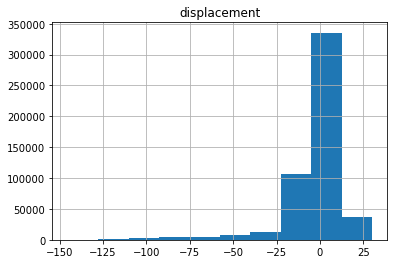

In [4]:
# from looking at the data we can see that the value -9999.0 is
# equivalent to missing data, so lets not consider those entries
df = df[df.displacement > -9999.0]

# look at the distribution again. it looks better this time
df.hist(column='displacement')
df.head()

In [5]:
# for this case I want to sample the grid more densely near the deformation source
from typing import List
from geopy import Point
from geopy.distance import distance
import numpy
from numpy.random import randint

# 2D location estimate
deformation_Source = [-121.835, 44.090]

# find all points within a 10 km radius from the deformation source using a function
def ellipsoidal_Distance(point1: List[float], point2: List[float]) -> float:
    """Returns the distance between two points on Earth.

    Inputs (in decimal degrees):
            point1: list[longitude, latitude]
            point2: list[longitude, latitude]
    """
    longitude1, latitude1 = point1
    longitude2, latitude2 = point2
    point1_object = Point(latitude1, longitude1)
    point2_object = Point(latitude2, longitude2)
    distance_2D = distance(point1_object, point2_object).km
    return abs(distance_2D)

# loop through df rows and record the distance from each point to the source
distance_From_Source_List = []
for row in range(len(df)):
    distance_From_Source = ellipsoidal_Distance([df.iloc[row , 0], df.iloc[row , 1]], deformation_Source)
    distance_From_Source_List.append(distance_From_Source)

# append list to df as new column
df['distance_from_source'] = distance_From_Source_List

# exclude data > 15 km from source
df = df[df.distance_from_source <= 15.0]

# save data within and outside 10km as new dataframes
within_10km_df = df[df.distance_from_source <= 10.0]
outside_10km_df = df[df.distance_from_source > 10.0]

# generate pseudorandom indices to sample from each subset
numpy.random.seed(44) # set seed for reproducibility
within_Indices = randint(len(within_10km_df), size=45)
outside_Indices = randint(len(outside_10km_df), size=40)
within_10km_df = within_10km_df.iloc[within_Indices, [0, 1, 2]]
outside_10km_df = outside_10km_df.iloc[outside_Indices, [0, 1, 2]]

# print the contents to verify they aren't garbage
print("Within 10 km subset:")
print(within_10km_df)
print("\nOutside 10 km subset:")
print(outside_10km_df)

# merge the dataframes to save to a single file
result = pd.concat([within_10km_df, outside_10km_df])
# shuffle the rows of the dataframe
result = result.sample(frac=1).reset_index(drop=True)
# save subsets combined as one csv file
result.to_csv("sisters.csv", index=False, header=True)

Within 10 km subset:
         longitude   latitude  displacement
383727 -121.907500  44.120000    -34.945660
345204 -121.771667  44.158333    -12.307207
423381 -121.801667  44.080833    -93.306717
348486 -121.840000  44.155000    -51.707291
399756 -121.865833  44.104167    -96.620819
343427 -121.850833  44.160000    -44.205322
487290 -121.807500  44.017500    -22.578447
470390 -121.874167  44.034167    -35.428940
376334 -121.760833  44.127500    -39.644669
392359 -121.722500  44.111667    -20.937958
398082 -121.859167  44.105833   -102.929306
343423 -121.854167  44.160000    -41.262115
414912 -121.850833  44.089167   -129.849106
362743 -121.873333  44.140833    -46.753193
471209 -121.892500  44.033333    -31.379253
499019 -121.845000  44.005833     -9.652740
393967 -121.784167  44.110000    -72.440643
384662 -121.829167  44.119167   -101.745483
415791 -121.819167  44.088333   -119.644028
435111 -121.838333  44.069167   -100.859879
387983 -121.865000  44.115833    -85.317474
392110 -121

In [6]:
################################
# plot the subsampled csv file #
################################

# feed the data to gmt, write to resampled_grid.png
! gmt begin resampled_grid png

    # create the map frame and set the region and projection
!    gmt basemap -R$XMIN/$XMAX/$YMIN/$YMAX -JM15c -Baf

    # plot topography using gmt built-in dataset at the highest resolution
!    gmt grdimage @earth_relief_01s -Cgray -I+d

    # make a new colormap that only covers the values of interest for the grid
!    gmt makecpt -Cseis -T-140/35

    # plot points colored by displacement (mm)
!    gmt plot sisters.csv -Sc0.2c -C

    # show the colorbar, ticks every 25 mm, add title
!    gmt colorbar -B25 -Bx+l"range change [mm]"

#     # to plot a fake point source 
# !    echo -121.835 44.090 > t.dat
# !    gmt plot t.dat -Gblack -Sc0.1c

! gmt end show

grdblend [WARNING]: File @N40W130.earth_relief_15s_p.nc has different increments (0.00416666666667/0.00416666666667) than the output grid (0.000277777777778/0.000277777777778) - must resample
grdblend [WARNING]: File @N40W130.earth_relief_15s_p.nc coordinates are phase-shifted w.r.t. the output grid - must resample
